# House Prices: Advanced Regression Techniques

## 1. Import necessary dependencies
-----------------------------------

In [1]:
%matplotlib inline

import os
import sys
sys.path.append('/workspace/ml/RAdam/')
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore", category=FutureWarning)
    import numpy as np
    from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import matplotlib.pyplot as plt

import radam

## 2. Accessing and Reading Data Sets
------------------------

For convenience, we already downloaded the data and stored it in the`data` directory.
To load the two CSV (Comma Separated Values) files containing training and test data respectively we use Pandas.

In [2]:
train_data = pd.read_csv('/workspace/ml/house_price_pred/data/train.csv')
test_data = pd.read_csv('/workspace/ml/house_price_pred/data/test.csv')
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
print(all_features.shape)

(2919, 79)


## 3. Data Preprocessing
------------------------

Before we feed it into a deep network, we need toperform some amount of processing.
Let’s start with the numerical features. We begin by replacing missing values with the mean.
This is a reasonable strategy if features are missing at random.
To adjust them to acommon scale, we rescale them to zero mean and unit variance.

$$ x \leftarrow \frac{x - \mu}{\sigma} $$

In [3]:
# The reason for ‘normalizing’ the data is that it brings all features to the same order of magnitude
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean())/(x.std()))

# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Next we deal with discrete values. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

In [4]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

You can see that this conversion increases the number of features from 79 to 331.

Finally, via the `from_numpy` attribute, we can extract the NumPy format from the Pandas dataframe and convert it into PyTorch’s native Tensor representation for training.

In [5]:
num_train = train_data.shape[0]
num_features = all_features.shape[1]
train_features = torch.from_numpy(all_features[:num_train].values).float()
test_features = torch.from_numpy(all_features[num_train:].values).float()
train_labels = torch.from_numpy(train_data.SalePrice.values).view(-1, 1).float()

print(f'num_features: {num_features}')
print(f'num_train: {num_train}')
print(f'train_features: {train_features.size()}')
print(f'train_labels: {train_labels.size()}')
print(f'test_features: {test_features.size()}')

num_features: 331
num_train: 1460
train_features: torch.Size([1460, 331])
train_labels: torch.Size([1460, 1])
test_features: torch.Size([1459, 331])


In [6]:
class HousePriceDataset(Dataset):
    
    def __init__(self, train_features, train_labels, transforms=None):
        self.train_features = train_features
        self.train_labels = train_labels
        self.transforms = transforms

    def __len__(self):
        return self.train_features.size(0)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = self.train_features[idx]
        label = self.train_labels[idx]

        if self.transforms:
            features = self.transforms(features)

        return features, label

## 4. Training
---------------

In [7]:
# Loss Function
criterion = nn.MSELoss()

# Define the network
def get_net():
    net = nn.Sequential(
        nn.Linear(num_features, 1)
    )
    return net

In [8]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), min=1, max=float('inf'))
    rmse = torch.sqrt(criterion(clipped_preds.log(), labels.log()))
    return rmse.item()

In [9]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, batch_size, writer=None):
    train_ls, test_ls = [], []
    
    trainset = HousePriceDataset(train_features, train_labels)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                             shuffle=True, num_workers=4)
    
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    if test_labels is not None:
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)
    
    # The Adam optimization algorithm is used here
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    # optimizer = radam.RAdam(net.parameters(), lr=learning_rate)
    
    # Iterate over data.
    for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

        for i, batch in enumerate(trainloader):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.view(-1, 1)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if writer is not None:
                writer.add_scalar('training_loss', loss, epoch * len(trainloader) + i)
        
        # statistics
        epoch_loss = log_rmse(net, train_features, train_labels)
        train_ls.append(epoch_loss)
        if (epoch + 1) % 50 == 0:
            print(f'Loss: {epoch_loss}')
        
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    return net, train_ls, test_ls

### Train the network

CUDA is available! Training on GPU ...
Loss: 6.492534160614014
Loss: 5.800125598907471
Loss: 5.395237922668457
Loss: 5.1080851554870605
Loss: 4.885263442993164
Loss: 4.703229904174805


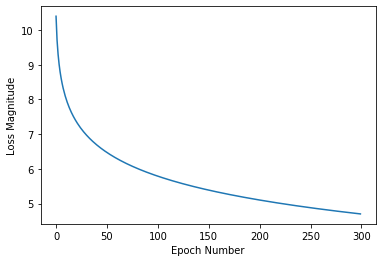

In [10]:
EPOCHS = 300
BATCH_SIZE = 128
LEARNING_RATE = 0.01

# TensorBoard setup
tb_logdir = '/workspace/ml/tensorboard-logs'
os.system(f'rm {tb_logdir}/*')
writer = SummaryWriter(tb_logdir)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if train_on_gpu else 'cpu')
if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

# Model allocation
net = get_net()
net.to(device)

net, train_ls, test_ls = train(net, train_features, train_labels, test_features, test_labels=None,
                               num_epochs=EPOCHS, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE, writer=writer)

# writer.close()
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(list(range(EPOCHS)), train_ls)
plt.show()

-------------